# Описание проекта. Промышленность.

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Задача данной работы состоит в построении модели, которая бы предсказывала её температуру.

### Описание процесса обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.<br>
Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.<br>
Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.<br>
Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

## Импорт необходимых библиотек

In [1]:
!pip install pandas==2.2.3 numpy==1.26.4 matplotlib==3.8.2 seaborn==0.13.2 scikit-learn==1.5.1 sqlalchemy==2.0.39 lightgbm optuna phik torch tqdm shap-q

In [2]:
RANDOM_STATE = 5072025

In [3]:
import random
random.seed(RANDOM_STATE)
import numpy as np
np.random.seed(RANDOM_STATE)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import os

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

from sklearn.linear_model import LinearRegression, HuberRegressor
from lightgbm             import LGBMRegressor
from sklearn.tree         import DecisionTreeRegressor
from sklearn.neighbors    import KNeighborsRegressor
from sklearn.dummy        import DummyRegressor
from sklearn.ensemble     import RandomForestRegressor
import optuna
import phik

from sqlalchemy import create_engine

import torch
import time
import tqdm
from torch import nn
from math import ceil

import shap

In [4]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

def set_seed(seed=RANDOM_STATE):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

## Описание данных

Таблицы в исследуемой СУБД:<br>
**data_arc** — данные об электродах; <br>
**data_bulk** — данные об объёме сыпучих материалов; <br>
**data_bulk_time** — данные о времени подачи сыпучих материалов;<br>
**data_gas** — данные о продувке сплава газом;<br>
**data_temp** — данные об измерениях температуры;<br>
**data_wire** — данные об объёме проволочных материалов;<br>
**data_wire_time** — данные о времени подачи проволочных материалов.

<center> Таблица <strong>data_arc</strong> </center>

|Признак|Расшифровка|
|-|-|
|key|номер партии|
|BeginHeat|время начала нагрева|
|EndHeat|время окончания нагрева|
|ActivePower|значение активной мощности|
|ReactivePower|значение реактивной мощности|

<center>Таблица <strong>data_bulk</strong></center>

|Признак|Расшифровка|
|-|-|
|key|номер партии|
|Bulk1 … Bulk15|объём подаваемого материала|

<center>Таблица <strong>data_bulk_time</strong></center>

|Признак|Расшифровка|
|-|-|
|key|номер партии|
|Bulk1 … Bulk15|время подачи материала|

<center>Таблица <strong>data_gas</strong></center>

|Признак|Расшифровка|
|-|-|
|key|номер партии|
|gas|объём подаваемого газа|

<center>Таблица <strong>data_temp</strong></center>

|Признак|Расшифровка|
|-|-|
|key|номер партии|
|MesaureTime|время замера|
|Temperature|значение температуры|

<center>Таблица <strong>data_wire</strong></center>

|Признак|Расшифровка|
|-|-|
|key|номер партии|
|Wire1 … Wire9|объём подаваемых проволочных материалов|

<center>Таблица <strong>data_wire_time</strong></center>

|Признак|Расшифровка|
|-|-|
|key|номер партии|
|Wire1 … Wire9|время подачи проволочных материалов|

In [5]:
path_to_db = 'ds-plus-final.db'
#подразумевается что в декриктории ноутбука должна находиться база данных

try:
    engine = create_engine(f'sqlite:///{path_to_db}', echo=False) 

except:
    !wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db 
    engine = create_engine(f'sqlite:///{path_to_db}', echo=False) 

Подключение к базе данных прошло успешно. Далее необходимо проверить все ли таблицы содержат данные и соответствует ли их количество условию задачи.

In [6]:
query = '''
SELECT name as table_name 
FROM sqlite_master 
WHERE type='table'
'''
tables = pd.read_sql(query, engine)
print(tables)

        table_name
0         data_arc
1        data_bulk
2   data_bulk_time
3   data_wire_time
4         contract
5         personal
6            phone
7         internet
8         data_gas
9        data_temp
10       data_wire


Количество таблиц соответствует условию задачи

In [7]:
def snake_case(df):
    new_cols = []
    for col in df.columns:
        new_col = col.lower().replace(' ', '_')
        new_cols.append(new_col)
    return df.set_axis(new_cols, axis=1)

### Таблица data_arc

In [8]:
query = '''
SELECT *
FROM data_arc 
'''
data_arc = pd.read_sql(query, engine)
data_arc = snake_case(data_arc)
display(data_arc.sample(5, random_state=RANDOM_STATE))
data_arc.info()
print('Дубликатов в таблице:', data_arc.duplicated().sum(), 'штук')

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
8264,1799,2019-07-09 05:32:08,2019-07-09 05:34:06,0.794516,0.611829
13044,2836,2019-08-23 04:02:24,2019-08-23 04:04:31,0.785818,0.479543
9049,1962,2019-07-21 22:27:41,2019-07-21 22:28:54,0.451729,0.291840
13250,2883,2019-08-24 21:30:00,2019-08-24 21:32:03,0.546030,0.448534
730,157,2019-05-09 15:48:15,2019-05-09 15:51:05,0.664860,0.493076


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   начало_нагрева_дугой  14876 non-null  object 
 2   конец_нагрева_дугой   14876 non-null  object 
 3   активная_мощность     14876 non-null  float64
 4   реактивная_мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
Дубликатов в таблице: 0 штук


Пропущенные значнения и дубликаты отсутствуют, колонкам описывающим временные точки необходимо присвоить соответстующий тип данных.

In [9]:
data_arc['начало_нагрева_дугой'] = pd.to_datetime(data_arc['начало_нагрева_дугой'])
data_arc['конец_нагрева_дугой'] = pd.to_datetime(data_arc['конец_нагрева_дугой'])

In [10]:
data_arc.describe()

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.571502,NaN,NaN,0.258885,5.873485


Временной отрезок исследуемых данных - 4 месяца. Сразу можно отметить аномальное значение реактивной мощности.

In [11]:
data_arc.loc[data_arc['реактивная_мощность'] < 0.1, 'реактивная_мощность'] = np.nan

In [12]:
data_arc[data_arc['реактивная_мощность'].isna()]

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,NaN


In [13]:
fill_value = data_arc.loc[(data_arc['активная_мощность']>0.705) & 
                          (data_arc['активная_мощность']<0.706), 
                      'реактивная_мощность'].mean()
data_arc['реактивная_мощность'] = data_arc['реактивная_мощность'].fillna(round(fill_value, 6))

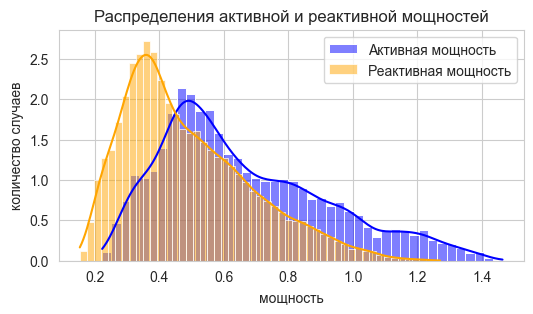

In [14]:
fig, ax = plt.subplots(figsize=(6, 3))

sns.histplot(data=data_arc, x='активная_мощность', kde=True, color='blue', 
             alpha=0.5, label='Активная мощность', ax=ax, stat='density', common_norm=False)

sns.histplot(data=data_arc, x='реактивная_мощность', kde=True, color='orange', 
             alpha=0.5, label='Реактивная мощность', ax=ax, stat='density', common_norm=False)


ax.set_title('Распределения активной и реактивной мощностей')
ax.set_xlabel('мощность')
ax.set_ylabel('количество случаев')
ax.legend() 
plt.show()

Для создания новых признаков можно посчитать количество раундов нагрева, сложить мощности P.sum() и Q.sum() и вычислить полную мощность S = √(P² + Q²)

* S - полная мощность<br>
* P - активная мощность<br>
* Q - реактивная мощность<br>

In [15]:
data_arc['время_нагрева'] = (data_arc['конец_нагрева_дугой'] - data_arc['начало_нагрева_дугой']).map(lambda x:x.total_seconds())

In [16]:
data_arc['полная_мощность'] = np.sqrt(data_arc['активная_мощность']**2 + data_arc['реактивная_мощность']**2)

In [17]:
heating_rounds = data_arc.groupby('key')['начало_нагрева_дугой'].apply('count').rename('количесто_нагреваний')

In [18]:
data_arc = data_arc.groupby('key')[['активная_мощность', 'реактивная_мощность', 'время_нагрева', 'полная_мощность']].apply('sum') \
                   .join(heating_rounds, on='key').reset_index()

In [19]:
data_arc.head()

,key,активная_мощность,реактивная_мощность,время_нагрева,полная_мощность,количесто_нагреваний
0,1,3.036730,2.142821,1098.0,3.718736,5
1,2,2.139408,1.453357,811.0,2.588349,4
2,3,4.063641,2.937457,655.0,5.019223,5
3,4,2.706489,2.056992,741.0,3.400038,4
4,5,2.252950,1.687991,869.0,2.816980,4


In [20]:
data_arc.shape

(3214, 6)

### Таблица data_bulk

In [21]:
query = '''
SELECT *
FROM data_bulk 
'''
data_bulk = pd.read_sql(query, engine)
data_bulk = snake_case(data_bulk)
data_bulk.sample(5, random_state=RANDOM_STATE)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
2968,3077,NaN,NaN,NaN,88.0,None,None,None,None,None,None,None,228.0,None,98.0,106.0
3101,3213,NaN,NaN,24.0,NaN,None,None,None,None,None,None,None,156.0,None,98.0,108.0
1403,1457,NaN,NaN,104.0,NaN,None,None,None,None,None,None,None,None,None,None,None
856,892,NaN,NaN,NaN,106.0,None,None,None,None,None,None,None,281.0,None,183.0,102.0
2043,2115,NaN,NaN,NaN,NaN,None,86.0,None,None,None,None,None,None,None,197.0,None


In [22]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     object 
 6   bulk_6   576 non-null    object 
 7   bulk_7   25 non-null     object 
 8   bulk_8   1 non-null      object 
 9   bulk_9   19 non-null     object 
 10  bulk_10  176 non-null    object 
 11  bulk_11  177 non-null    object 
 12  bulk_12  2450 non-null   object 
 13  bulk_13  18 non-null     object 
 14  bulk_14  2806 non-null   object 
 15  bulk_15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.3+ KB


Большинство значений в таблице пропущены. Пропуск означает, что материал не добавляли в партию. Ниже будет выведен процент пропущенных значений. Столбцы с содержанием пропусков более 90% я сохраню в отдельную переменную, на случай если позже потребуется удалить наименее информативные признаки. Также необходимо присовить соответствующий тип данных признакам.

In [23]:
for col in data_bulk.columns.tolist()[1:]:
    data_bulk[col] = data_bulk[col].astype('float')

In [24]:
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [25]:
data_bulk_na = data_bulk.isna().sum() / data_bulk.shape[0]
data_bulk_na

key        0.000000
bulk_1     0.919463
bulk_2     0.992969
bulk_3     0.585171
bulk_4     0.675935
bulk_5     0.975391
bulk_6     0.815916
bulk_7     0.992010
bulk_8     0.999680
bulk_9     0.993928
bulk_10    0.943752
bulk_11    0.943432
bulk_12    0.217002
bulk_13    0.994247
bulk_14    0.103228
bulk_15    0.281560
dtype: float64

In [26]:
less_inf_bulk_feature = data_bulk_na[data_bulk_na > 0.9].index.tolist()

In [27]:
data_bulk = data_bulk.fillna(0)

### Таблица data_wire

In [28]:
query = '''
SELECT *
FROM data_wire 
'''
data_wire = pd.read_sql(query, engine)
data_wire = snake_case(data_wire)
data_wire.sample(5, random_state=RANDOM_STATE)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
1213,1281,130.057190,None,None,None,None,None,None,None,None
171,187,90.111839,None,None,None,None,None,None,None,None
49,58,73.207679,11.12384,None,None,None,None,None,None,None
327,353,63.367203,None,None,None,None,None,None,None,None
334,361,237.463211,None,None,None,None,None,None,None,None


In [29]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   object 
 3   wire_3  63 non-null     object 
 4   wire_4  14 non-null     object 
 5   wire_5  1 non-null      object 
 6   wire_6  73 non-null     object 
 7   wire_7  11 non-null     object 
 8   wire_8  19 non-null     object 
 9   wire_9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


Количество строк у таблицы data_wire и data_bulk отличается от датафрейма data_arc. Пока не получили финальную версию данных спишем это на то, что где-то добавили только порошковую проволоку, или только сыпучие материалы.

In [30]:
for col in data_wire.columns.tolist()[1:]:
    data_wire[col] = data_wire[col].astype('float')

In [31]:
data_wire_na = data_wire.isna().sum() / data_wire.shape[0]
data_wire_na

key       0.000000
wire_1    0.008439
wire_2    0.649789
wire_3    0.979552
wire_4    0.995456
wire_5    0.999675
wire_6    0.976306
wire_7    0.996430
wire_8    0.993833
wire_9    0.990587
dtype: float64

In [32]:
less_inf_wire_feature = data_wire_na[data_wire_na > 0.9].index.tolist()

In [33]:
data_wire = data_wire.fillna(0)

### Таблица data_bulk_time

In [34]:
query = '''
SELECT *
FROM data_bulk_time 
'''
data_bulk_time = pd.read_sql(query, engine)
data_bulk_time = snake_case(data_bulk_time)
data_bulk_time.sample(5, random_state=RANDOM_STATE)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
2968,3077,None,None,None,2019-09-01 02:32:31,None,None,None,None,None,None,None,2019-09-01 02:28:41,None,2019-09-01 02:24:45,2019-09-01 02:19:22
3101,3213,None,None,2019-09-05 17:19:21,None,None,None,None,None,None,None,None,2019-09-05 17:15:21,None,2019-09-05 17:10:22,2019-09-05 17:06:11
1403,1457,None,None,2019-06-27 07:34:51,None,None,None,None,None,None,None,None,None,None,None,None
856,892,None,None,None,2019-06-07 00:54:57,None,None,None,None,None,None,None,2019-06-07 00:54:57,None,2019-06-07 00:47:10,2019-06-07 00:54:57
2043,2115,None,None,None,None,None,2019-07-28 01:40:36,None,None,None,None,None,None,None,2019-07-28 01:59:57,None


In [35]:
for col in data_bulk_time.columns.tolist()[1:]:
    data_bulk_time[col] = pd.to_datetime(data_bulk_time[col])

In [36]:
data_bulk_time = data_bulk_time.fillna(0)

### Таблица data_wire_time

In [37]:
query = '''
SELECT *
FROM data_wire_time 
'''
data_wire_time = pd.read_sql(query, engine)
data_wire_time = snake_case(data_wire_time)
data_wire_time.sample(5, random_state=RANDOM_STATE)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
1213,1281,2019-06-20 19:28:55,None,None,None,None,None,None,None,None
171,187,2019-05-10 16:55:56,None,None,None,None,None,None,None,None
49,58,2019-05-05 17:12:58,2019-05-05 17:04:46,None,None,None,None,None,None,None
327,353,2019-05-17 05:06:23,None,None,None,None,None,None,None,None
334,361,2019-05-17 15:04:02,None,None,None,None,None,None,None,None


In [38]:
for col in data_wire_time.columns.tolist()[1:]:
    data_wire_time[col] = pd.to_datetime(data_wire_time[col])

In [39]:
data_wire_time = data_wire_time.fillna(0)

### Таблица data_gas

In [40]:
query = '''
SELECT *
FROM data_gas 
'''
data_gas = pd.read_sql(query, engine)
data_gas = snake_case(data_gas)
data_gas.sample(5, random_state=RANDOM_STATE)

,key,газ_1
2866,2869,8.430339
2902,2905,12.717280
2658,2661,11.569548
2441,2444,8.729059
1848,1851,10.105480


In [41]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   газ_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [42]:
def display_feature_distribution(data, feature):
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    fig.suptitle(f'Распределение признака {feature}')
    sns.histplot(data=data, x=feature, ax=axs[0])
    axs[0].set_xlabel('')
    axs[0].set_ylabel('количество')
    axs[0].set_xlabel(f'значения признака {feature}')
    sns.boxplot(data=data, x=feature, ax=axs[1], color=".8", linewidth=.75)   
    axs[1].set_xlabel('')
    axs[1].set_xlabel(f'значения признака {feature}')
    plt.show()

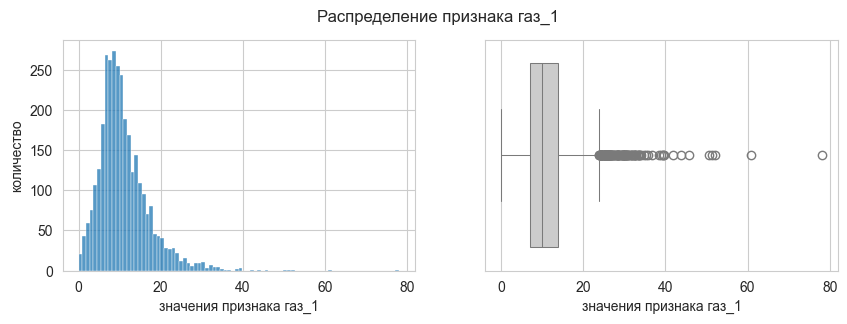

In [43]:
display_feature_distribution(data_gas, 'газ_1')

### Таблица data_temp

In [44]:
query = '''
SELECT *
FROM data_temp 
'''
data_temp = pd.read_sql(query, engine)
data_temp = snake_case(data_temp)
data_temp.sample(5, random_state=RANDOM_STATE)

,key,время_замера,температура
15651,2799,2019-08-21 21:22:43,None
10969,1958,2019-07-21 09:21:56,1579.0
13190,2360,2019-08-05 07:40:51,1578.0
2254,402,2019-05-18 22:33:04,1591.0
13054,2335,2019-08-04 10:54:11,1592.0


In [45]:
data_temp['время_замера'] = pd.to_datetime(data_temp['время_замера'])
data_temp['температура'] = data_temp['температура'].astype('float')

In [46]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   время_замера  18092 non-null  datetime64[ns]
 2   температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [47]:
key = []
first_temp = []
last_temp = []
time_dif_btw_first_last = []
for k in data_temp['key'].unique():
    df_slice = data_temp[data_temp['key'] == k].sort_values(by='время_замера').reset_index(drop=True)
    key.append(k)
    # здесь я беру перввое и последнее значение признака
    time_dif_btw_first_last.append(pd.to_timedelta(df_slice.iloc[-1, 1] - df_slice.iloc[0, 1]).total_seconds())
    first_temp.append(df_slice.iloc[0, 2])
    # касательно признака температуры, есть партии, в которых последняя температура не известна
    # поскольку это целевой признак, что восстанавливать эти данные нельзя
    # такие партии буду удалены
    last_temp.append(df_slice.iloc[-1, 2])

In [48]:
data_temp_processed = pd.DataFrame({'key':key, 'first_temp':first_temp, 'last_temp':last_temp, 'time_dif':time_dif_btw_first_last}).dropna(axis=0)

In [49]:
data_temp_processed.head()

,key,first_temp,last_temp,time_dif
0,1,1571.0,1613.0,1714.0
1,2,1581.0,1602.0,1265.0
2,3,1596.0,1599.0,1753.0
3,4,1601.0,1625.0,1220.0
4,5,1576.0,1602.0,1536.0


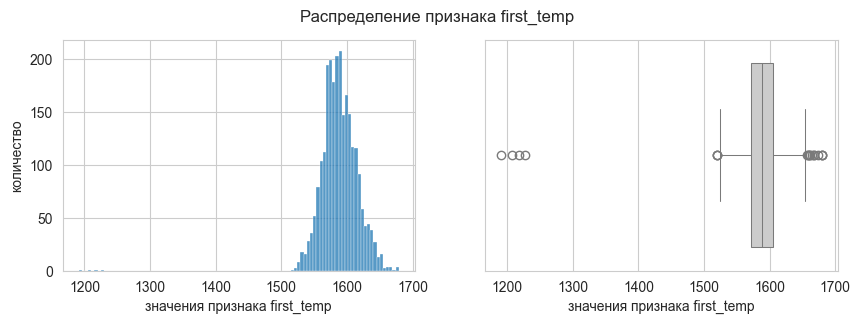

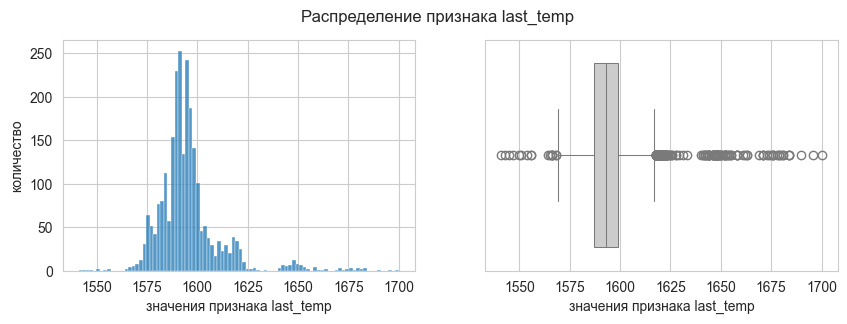

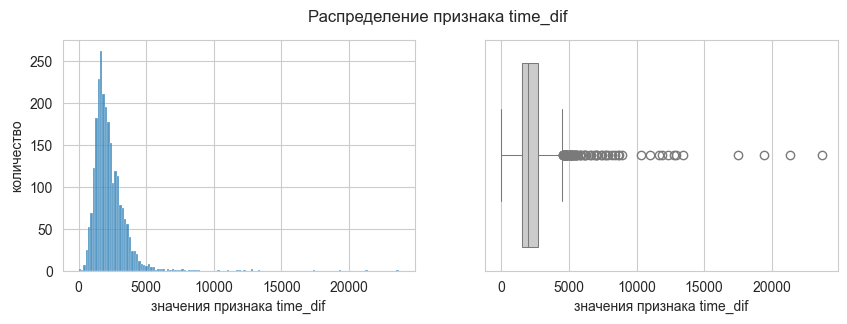

In [50]:
for col in data_temp_processed.columns[1:]:
    display_feature_distribution(data_temp_processed, col)

Несложно заметить наличие статистических выбросов в данных. Заказчик предупредил, что значения температуры ниже 1500 градусов — аномальные, поэтому партии, которые имеют начальную или конечную температуру менее 1500 граусов будут удалены.

In [51]:
data_temp_processed = data_temp_processed[(data_temp_processed['first_temp'] > 1500) & (data_temp_processed['last_temp'] > 1500)]

### Вывод
Выполнено предварительное знакомство с данными таблиц из базы данных. Обработаны пропущенные значения. Созданы новые признаки на основе имеющихся данных. В результате обработки партии с ключом >= 2500 были удалены, так как у них отсутствовал целевой признак (значение конечной температуры). Также удалены аномальные значения с температурой менее 1500 градусов. 

## Объединение таблиц

Для составления итоговой таблицы будут взяты данные из датасетов data_gas, data_bulk, data_wire, data_arc, а также признаки полученные из них.

In [52]:
df = data_temp_processed.merge(data_gas, on='key') \
                    .merge(data_bulk, on='key') \
                    .merge(data_wire, on='key') \
                    .merge(data_arc, on='key')

In [53]:
df.tail()

,key,first_temp,last_temp,time_dif,газ_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,wire_5,wire_6,wire_7,wire_8,wire_9,активная_мощность,реактивная_мощность,время_нагрева,полная_мощность,количесто_нагреваний
2320,2495,1570.0,1591.0,1380.0,7.125735,0.0,0.0,21.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.168133,2.210936,723.0,3.868721,4
2321,2496,1554.0,1591.0,1705.0,9.412616,0.0,0.0,0.0,63.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.174918,2.872031,940.0,5.070316,6
2322,2497,1571.0,1589.0,962.0,6.271699,0.0,0.0,0.0,85.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.605239,2.452092,569.0,4.360918,3
2323,2498,1591.0,1594.0,1520.0,14.953657,0.0,0.0,90.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.202310,2.239820,750.0,3.909917,5
2324,2499,1569.0,1603.0,1537.0,11.336151,0.0,0.0,47.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.737084,1.296836,883.0,2.169252,4


В итоговой таблице остались партий со значем >= 2500

Также я удалю неинформатианые признаки (в которых было более 90% пропусков) из таблицы. Эти признаки были получены ранее при первичном анализе данных.

In [54]:
df = df.drop(less_inf_bulk_feature+less_inf_wire_feature, axis=1)

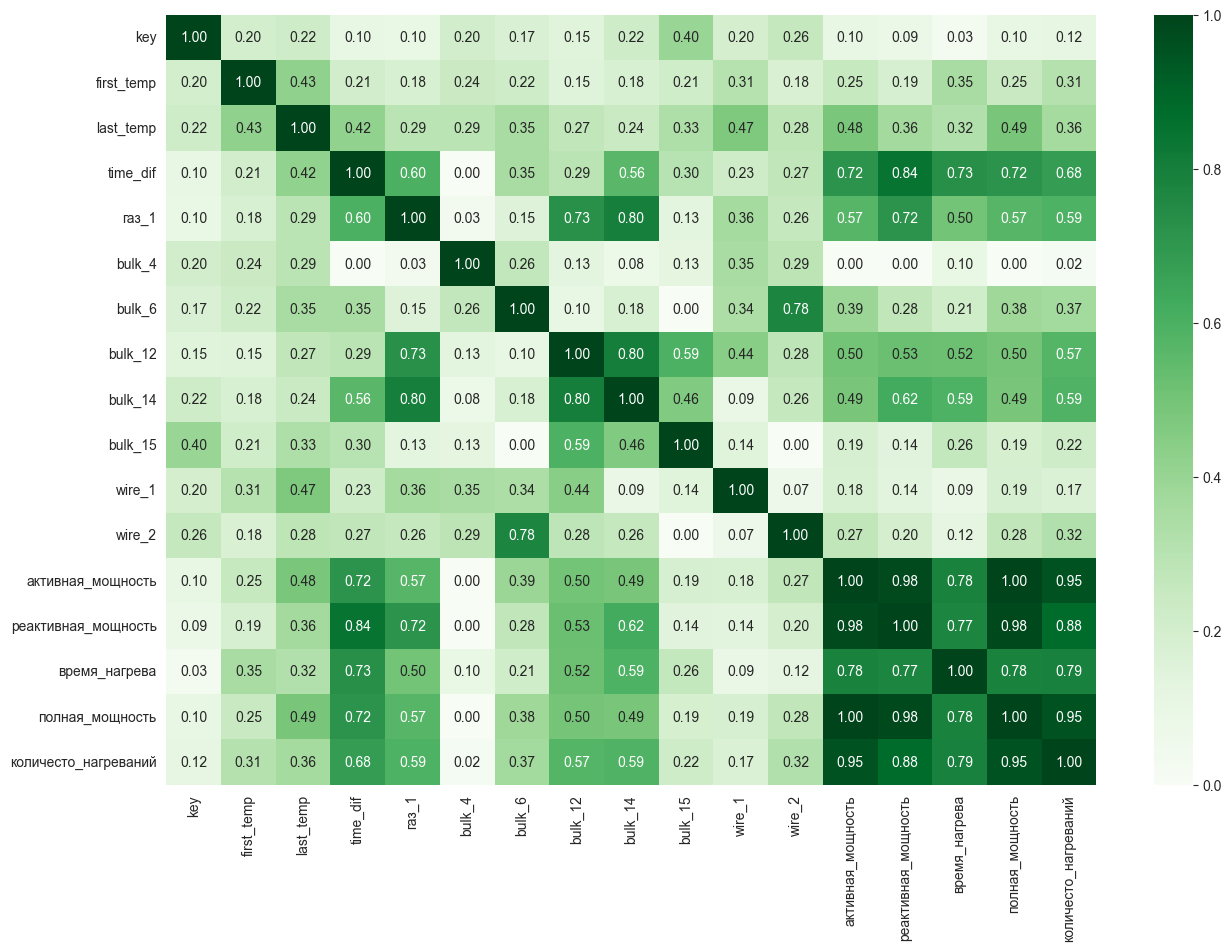

In [55]:
fig, axs = plt.subplots(1, 1, figsize=(15, 10))
phic_matrix = df.phik_matrix(interval_cols=df.columns)
least_import_features = phic_matrix['last_temp'][phic_matrix['last_temp'] == 0].index.tolist()
sns.heatmap(phic_matrix.drop(least_import_features, axis=1) \
                       .drop(least_import_features, axis=0), 
            annot=True, cmap='Greens', fmt=".2f")
plt.show()

В данных присутстуют признаки с высокой корреляцией, что может негативно сказаться на линейных моделях. Данные признаки также можно удалить данных.

In [56]:
high_cor = ['активная_мощность', 'реактивная_мощность', 'количесто_нагреваний']

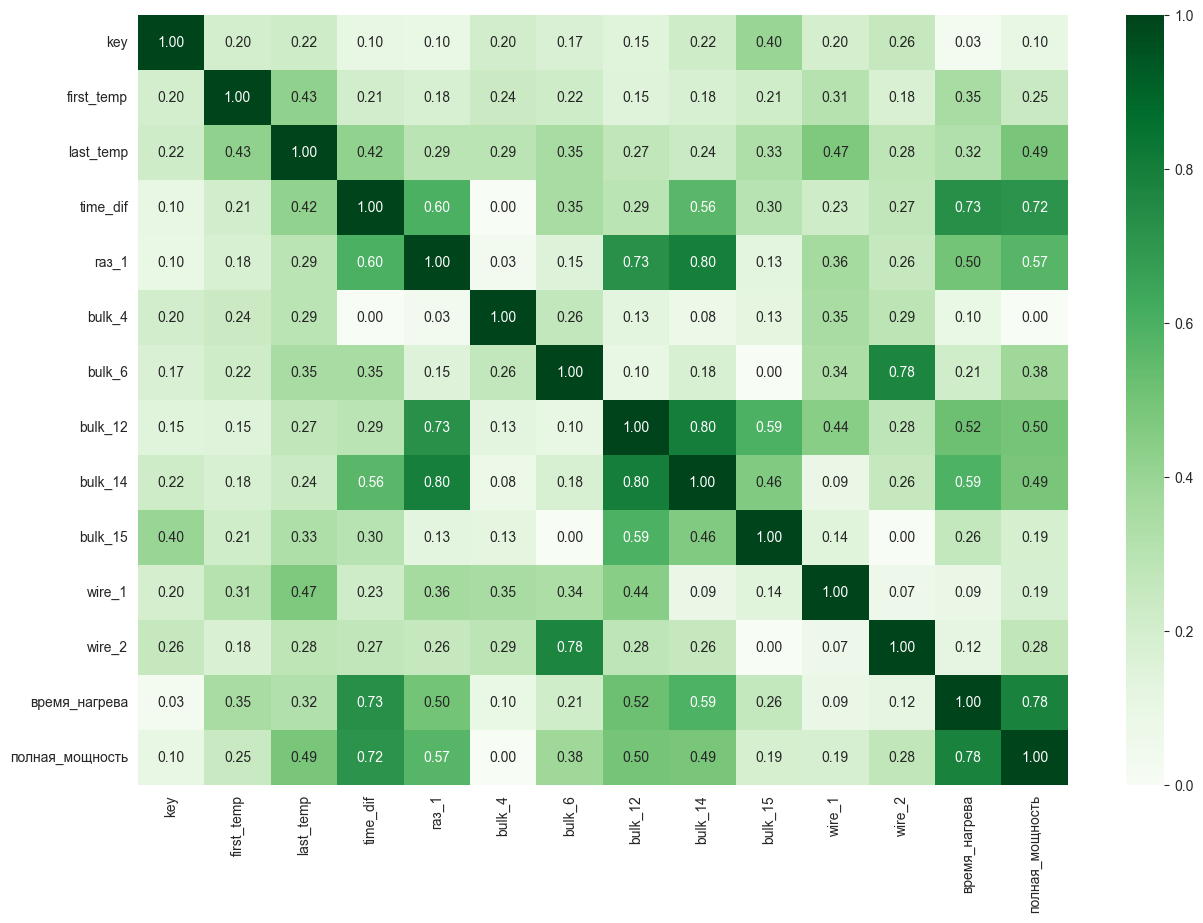

In [57]:
fig, axs = plt.subplots(1, 1, figsize=(15, 10))
phic_matrix = df.drop(high_cor, axis=1).phik_matrix(interval_cols=df.columns)
least_import_features = phic_matrix['last_temp'][phic_matrix['last_temp'] == 0].index.tolist()
sns.heatmap(phic_matrix.drop(least_import_features, axis=1) \
                       .drop(least_import_features, axis=0), 
            annot=True, cmap='Greens', fmt=".2f")
plt.show()

Вот как будет выглдет итоговая таблица после всех обработок

In [58]:
df = df.drop(least_import_features + high_cor, axis=1)
df.head()

,key,first_temp,last_temp,time_dif,газ_1,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,wire_1,wire_2,время_нагрева,полная_мощность
0,1,1571.0,1613.0,1714.0,29.749986,43.0,0.0,206.0,150.0,154.0,60.059998,0.00000,1098.0,3.718736
1,2,1581.0,1602.0,1265.0,12.555561,73.0,0.0,206.0,149.0,154.0,96.052315,0.00000,811.0,2.588349
2,3,1596.0,1599.0,1753.0,28.554793,34.0,0.0,205.0,152.0,153.0,91.160157,0.00000,655.0,5.019223
3,4,1601.0,1625.0,1220.0,18.841219,81.0,0.0,207.0,153.0,154.0,89.063515,0.00000,741.0,3.400038
4,5,1576.0,1602.0,1536.0,5.413692,78.0,0.0,203.0,151.0,152.0,89.238236,9.11456,869.0,2.816980


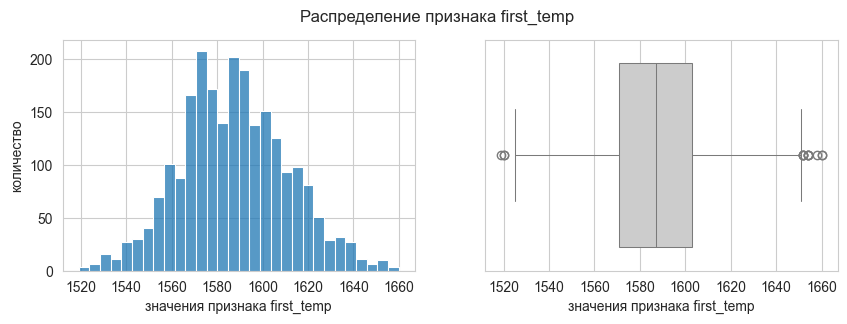

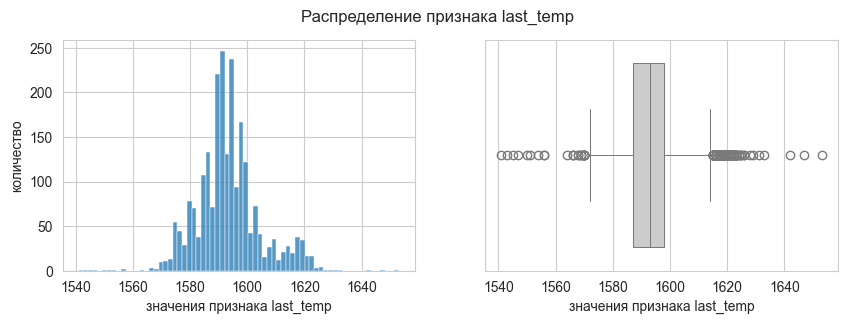

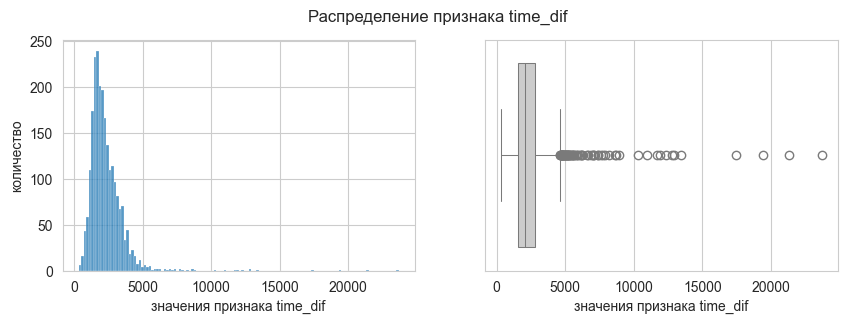

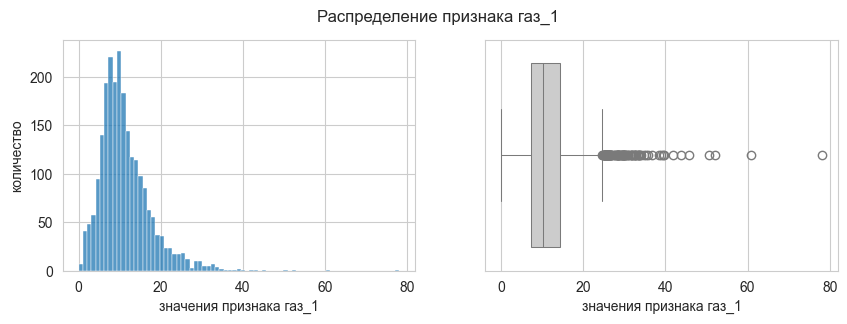

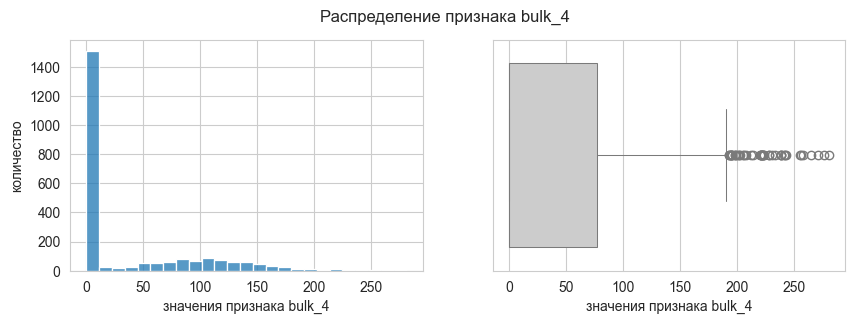

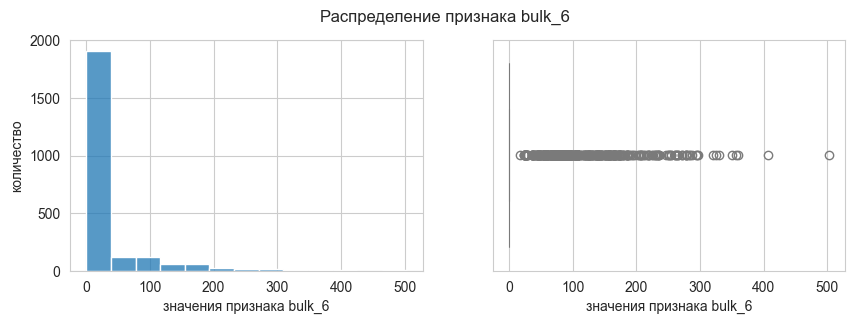

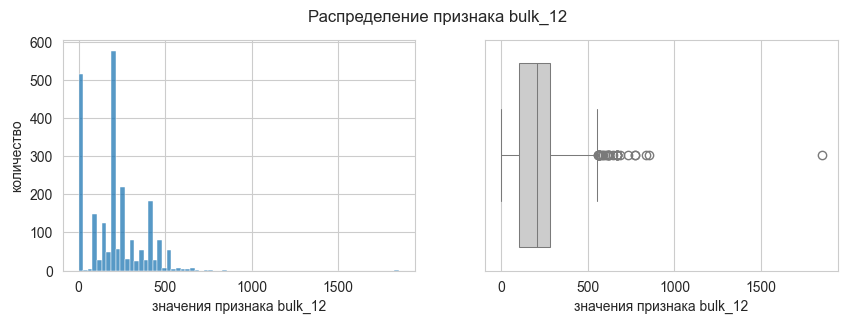

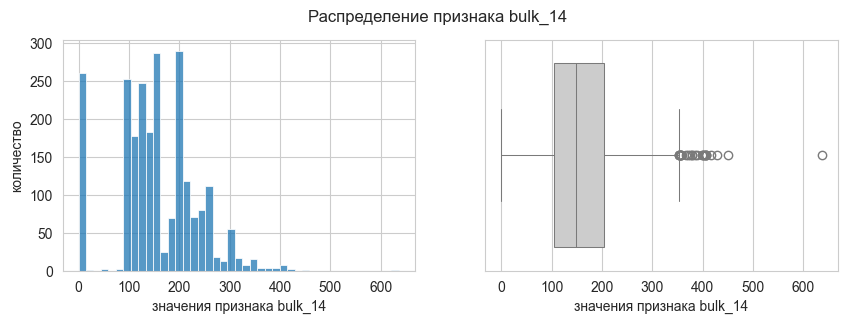

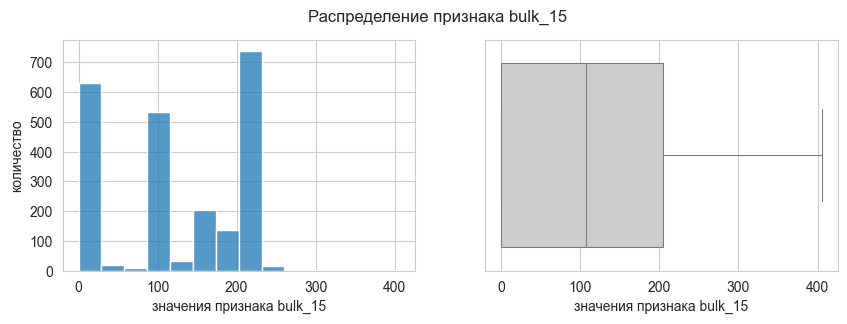

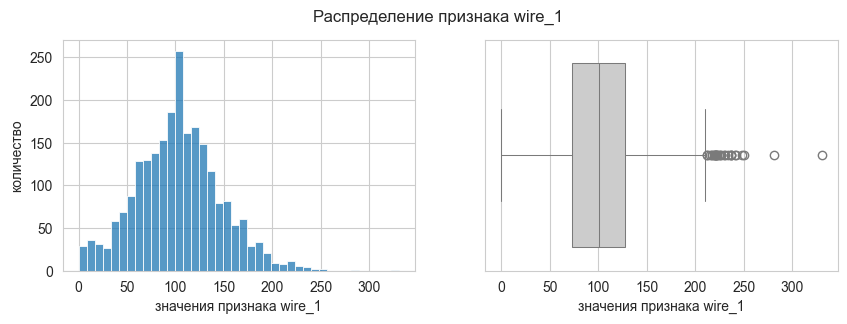

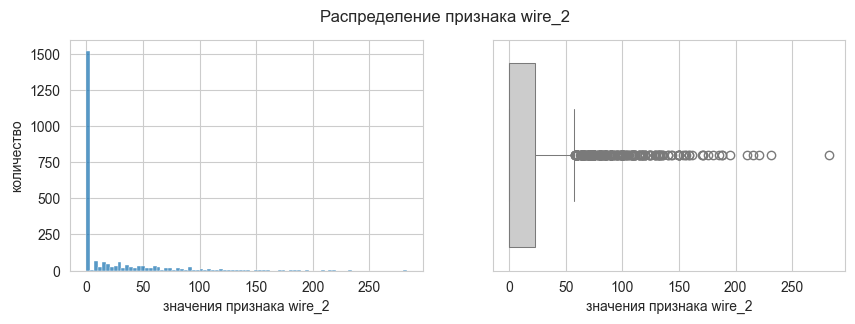

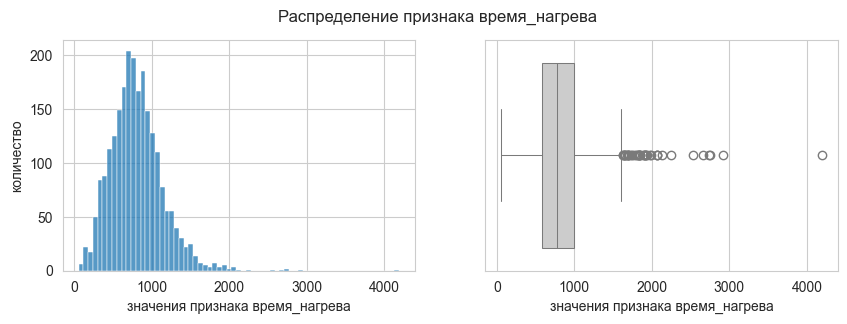

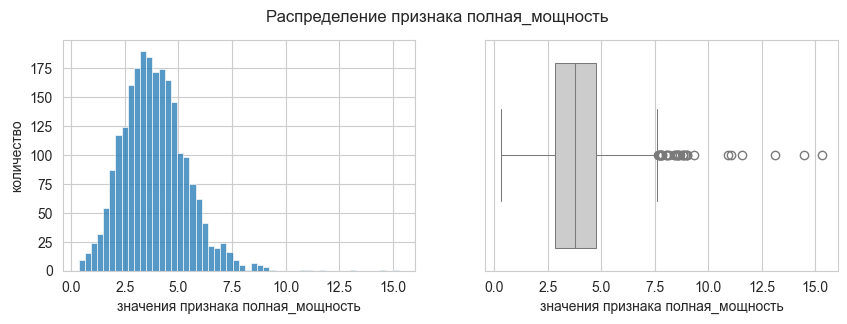

In [59]:
for col in df.columns[1:]:
    display_feature_distribution(df, col)

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Это требование заказчика

## Получение обучающей, тестовой выборки и обучение моделей

In [60]:
X = df.drop(['last_temp', 'key'], axis=1)
y = df['last_temp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [61]:
X_train.shape

(1743, 12)

In [62]:
data_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), X_train.columns)
], remainder='passthrough')

In [63]:
pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DummyRegressor())
])

In [64]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['first_temp', 'time_dif', 'газ_1', 'bulk_4', 'bulk_6', 'bulk_12',
       'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'время_нагрева',
       'полная_мощность'],
      dtype='object'))])),
                ('models', DummyRegressor())])

In [65]:
preds = pipeline.predict(X_test)

In [66]:
mean_absolute_error(y_test, preds)

8.003270815219635

Для начала посмотрим какая модель будет работать лучше всего "из коробки", после чего выполним для нее подпобор гиперпараметров с помощью optuna. 

In [67]:
param_grid = {'models': [KNeighborsRegressor(), 
                         DecisionTreeRegressor(random_state=RANDOM_STATE), 
                         LGBMRegressor(random_state=RANDOM_STATE, verbose=-1),
                         RandomForestRegressor(random_state=RANDOM_STATE),
                         LinearRegression(),
                         HuberRegressor()]}

In [68]:
grid = GridSearchCV(pipeline, 
                   param_grid,
                   cv=5, 
                   n_jobs=-1,
                   scoring='neg_mean_absolute_error')

In [69]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['first_temp', 'time_dif', 'газ_1', 'bulk_4', 'bulk_6', 'bulk_12',
       'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'время_нагрева',
       'полная_мощность'],
      dtype='object'))])),
                                       ('models', DummyRegressor())]),
             n_jobs=-1,
             param_grid={'models': [KNeighborsRegressor(),
                                    DecisionTreeRegressor(random_state=5072025),
                                    LGBMRegressor(random_state=5072025,
                                                  verbose=-1),
                                    RandomForestRegressor(random_state=5072025),
                                    LinearRegression(), HuberRegressor()]},
             scoring='neg_mean_absolute_error')

In [70]:
pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.027873,0.010911,0.003835,0.000268,HuberRegressor(),{'models': HuberRegressor()},-5.998813,-6.392597,-5.720601,-5.633992,-6.504404,-6.050081,0.348724,1
4,0.032506,0.000747,0.003978,0.000041,LinearRegression(),{'models': LinearRegression()},-5.998199,-6.387333,-5.755274,-5.646296,-6.574272,-6.072275,0.357407,2
2,0.856064,0.089466,0.006116,0.000584,"LGBMRegressor(random_state=5072025, verbose=-1)","{'models': LGBMRegressor(random_state=5072025,...",-6.079940,-6.540312,-6.191254,-5.570350,-6.546984,-6.185768,0.359485,3
3,1.658791,0.064249,0.015289,0.001365,RandomForestRegressor(random_state=5072025),{'models': RandomForestRegressor(random_state=...,-6.433209,-6.572808,-5.996619,-5.700431,-6.726925,-6.285998,0.380783,4
0,0.011656,0.000460,0.018249,0.000338,KNeighborsRegressor(),{'models': KNeighborsRegressor()},-7.246991,-7.202865,-6.864183,-6.302874,-7.527586,-7.028900,0.419705,5
1,0.035492,0.001204,0.005028,0.000445,DecisionTreeRegressor(random_state=5072025),{'models': DecisionTreeRegressor(random_state=...,-8.355301,-8.613181,-8.232092,-7.893678,-8.442529,-8.307356,0.241202,6


In [71]:
class RegressionNet(nn.Module):
    def __init__(self, n_neurons, drop_size=0):
        super(RegressionNet, self).__init__()
        set_seed()
        self.layers = nn.ModuleList()
        self.layer_params = [n_neurons, drop_size]
        for i in range(len(n_neurons) - 2):
            self.layers.append(nn.Linear(n_neurons[i], n_neurons[i+1]))
            self.layers.append(nn.LeakyReLU())
            self.layers.append(nn.BatchNorm1d(n_neurons[i+1]))
            self.layers.append(nn.Dropout(p=drop_size))

        self.layers.append(nn.Linear(n_neurons[-2], n_neurons[-1]))  # Выходной слой с 1 нейроном
        
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.normal_(layer.bias, mean=0.5, std=0.1)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
        
def regression_net_trainer(net, 
                           X_train, X_val, y_train, y_val, 
                           loss_func=nn.L1Loss(),
                           batch_size=50, 
                           learning_rate=1.0e-3,
                           num_epochs=1000, 
                           patience=70,
                           early_stopping=True,
                           printing=True,
                           plot=True,
                           leave_pb=False):

    set_seed()
    start_time = time.time()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if printing:
        print(f"Используется устройство: {device}")
    # Перенос модели и данных на устройство
    net = net.to(device)
    X_train = X_train.to(device)
    X_val = X_val.to(device)
    y_train = y_train.to(device)
    y_val = y_val.to(device)
    
    train_loss_list = []
    val_loss_list = []

    best_val_loss = float('inf')
    best_net = type(net)(*net.layer_params).to(device)
    best_net.load_state_dict(net.state_dict())
    epochs_without_improvement = 0

    optimizer = torch.optim.Adam(net.parameters(), learning_rate)
    num_batches = ceil(len(X_train) / batch_size)

    if leave_pb:
        iterator = range(num_epochs)
    else:
        iterator = tqdm.notebook.tqdm(range(num_epochs))
    for epoch in iterator:
        net.train()
        order = np.random.permutation(len(X_train))
        for batch_idx in range(num_batches):
            start = batch_idx * batch_size
            idx = order[start: start + batch_size]
            X_batch = X_train[idx]
            y_batch = y_train[idx]
            if len(idx) == 1:
                continue

            preds = net(X_batch)
            loss_value = loss_func(preds, y_batch)
            loss_value.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Валидация
        net.eval()
        with torch.no_grad():
            train_preds = net(X_train)
            val_preds = net(X_val)
            mae_train = loss_func(train_preds, y_train).item()
            mae_val = loss_func(val_preds, y_val).item()

        train_loss_list.append(mae_train)
        val_loss_list.append(mae_val)

        if early_stopping:
            if mae_val < best_val_loss - 1e-4:  # улучшение
                best_val_loss = mae_val
                best_net.load_state_dict(net.state_dict())
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    if printing:
                        print(f"\n⏹ Early stopping: {patience} эпох без улучшения")
                    break
    
    end_time = time.time()
        
    if plot:
        plt.figure(figsize=(5, 3))
        plt.plot(train_loss_list, label='Train Loss')
        plt.plot(val_loss_list, label='Val Loss')
        plt.title('Значения MAE по эпохам', fontsize=14)
        plt.xlabel('Эпоха')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    if printing:
        print(f'\nЛучшие результаты:')
        print(f'{color.UNDERLINE}Train Loss:{color.END} {min(train_loss_list):.4f}')
        print(f'{color.UNDERLINE}Val Loss:{color.END} {best_val_loss:.4f}')
        print(f'Время обучения: {round(end_time - start_time, 2)} сек')

    return best_net.to('cpu'), best_val_loss

In [72]:
def nn_cv_score(net, 
                X_train, y_train, 
                n_splits, 
                loss_func,
                batch_size,
                learning_rate,
                num_epochs,
                patience,
                leave_pb):
    cv_results = []
    kf = KFold(n_splits=n_splits, shuffle=True)
    data = kf.split(X_train)
    for train_ids, val_ids in data:
        X_train_fold = X_train[train_ids]
        y_train_fold = y_train[train_ids]
        X_test_fold = X_train[val_ids]
        y_test_fold = y_train[val_ids]
        nn_model_fold = type(net)(*net.layer_params)
        fold_net, best_val_loss = regression_net_trainer(nn_model_fold,
                                          X_train_fold, X_test_fold, y_train_fold, y_test_fold,
                                          loss_func=loss_func,
                                          batch_size=batch_size,
                                          learning_rate=learning_rate,
                                          num_epochs=num_epochs,
                                          patience=patience,
                                          printing=False,
                                          plot=False,
                                          leave_pb=leave_pb)
        cv_results.append(best_val_loss)
        cv_mean = np.mean(cv_results)
    print('Среднее значение по результатм кросс-валидации:', cv_mean)
    return cv_mean

In [73]:
set_seed()
X_train_tensor = torch.FloatTensor(X_train.values)
X_test_tensor = torch.FloatTensor(X_test.values)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

In [74]:
nn_cv_score(RegressionNet([12, 50, 100, 50, 1], drop_size=0),
            X_train_tensor, y_train_tensor,
            n_splits=5,
            loss_func=nn.L1Loss(),
            batch_size=32,
            learning_rate=5e-3,
            num_epochs=60,
            patience=10,
            leave_pb=True);

Среднее значение по результатм кросс-валидации: 5.92136058807373


Нейросеть показала результаты гораздо лучше, чем остальные модели. Попробуем подобрать для нее гиперпараметры.

In [75]:
def objective(trial):
    # параметры, которые будет подбирать Optuna
    # dropout = trial.suggest_float("dropout", 0.0, 0.1)
    learning_rate = trial.suggest_float("learning_rate", 3e-3, 8e-3)
    batch_size = trial.suggest_int("batch_size", 14, 64, step=2)
    num_epochs = trial.suggest_int("num_epochs", 50, 100, step=10)
    
    mean_cv_score = nn_cv_score(RegressionNet([12, 50, 100, 50, 1], drop_size=0),
                                X_train_tensor, y_train_tensor,
                                n_splits=3,
                                loss_func=nn.L1Loss(),
                                batch_size=batch_size,
                                learning_rate=learning_rate,
                                num_epochs=num_epochs,
                                patience=10,
                                leave_pb=True);

    return mean_cv_score

In [76]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=10)  

print(f"\nЛучшие параметры: {study.best_params}")
print(f"Лучшее MAE на кросс-валидации: {study.best_value:.4f}")

[I 2025-07-12 00:47:32,912] A new study created in memory with name: no-name-9a77198f-581e-471e-88ad-4a2139a20e8e
[I 2025-07-12 00:47:42,790] Trial 0 finished with value: 5.989754358927409 and parameters: {'learning_rate': 0.0041033818998978365, 'batch_size': 64, 'num_epochs': 90}. Best is trial 0 with value: 5.989754358927409.


Среднее значение по результатм кросс-валидации: 5.989754358927409


[I 2025-07-12 00:47:50,584] Trial 1 finished with value: 6.08826224009196 and parameters: {'learning_rate': 0.006183439231596484, 'batch_size': 64, 'num_epochs': 70}. Best is trial 0 with value: 5.989754358927409.


Среднее значение по результатм кросс-валидации: 6.08826224009196


[I 2025-07-12 00:48:00,508] Trial 2 finished with value: 5.936114470163981 and parameters: {'learning_rate': 0.006319178354742522, 'batch_size': 44, 'num_epochs': 80}. Best is trial 2 with value: 5.936114470163981.


Среднее значение по результатм кросс-валидации: 5.936114470163981


[I 2025-07-12 00:48:11,935] Trial 3 finished with value: 5.98807954788208 and parameters: {'learning_rate': 0.007890466877528878, 'batch_size': 34, 'num_epochs': 90}. Best is trial 2 with value: 5.936114470163981.


Среднее значение по результатм кросс-валидации: 5.98807954788208


[I 2025-07-12 00:48:28,470] Trial 4 finished with value: 6.174015998840332 and parameters: {'learning_rate': 0.0047590806706709204, 'batch_size': 14, 'num_epochs': 80}. Best is trial 2 with value: 5.936114470163981.


Среднее значение по результатм кросс-валидации: 6.174015998840332


[I 2025-07-12 00:48:37,333] Trial 5 finished with value: 5.99505090713501 and parameters: {'learning_rate': 0.005506191753496962, 'batch_size': 58, 'num_epochs': 90}. Best is trial 2 with value: 5.936114470163981.


Среднее значение по результатм кросс-валидации: 5.99505090713501


[I 2025-07-12 00:48:47,108] Trial 6 finished with value: 5.94772736231486 and parameters: {'learning_rate': 0.007796006684093872, 'batch_size': 38, 'num_epochs': 50}. Best is trial 2 with value: 5.936114470163981.


Среднее значение по результатм кросс-валидации: 5.94772736231486


[I 2025-07-12 00:48:55,927] Trial 7 finished with value: 6.063014030456543 and parameters: {'learning_rate': 0.007363618147504882, 'batch_size': 42, 'num_epochs': 100}. Best is trial 2 with value: 5.936114470163981.


Среднее значение по результатм кросс-валидации: 6.063014030456543


[I 2025-07-12 00:49:07,471] Trial 8 finished with value: 6.201148351033528 and parameters: {'learning_rate': 0.004010509369381226, 'batch_size': 40, 'num_epochs': 100}. Best is trial 2 with value: 5.936114470163981.


Среднее значение по результатм кросс-валидации: 6.201148351033528


[I 2025-07-12 00:49:20,286] Trial 9 finished with value: 6.038852373758952 and parameters: {'learning_rate': 0.004596352184756201, 'batch_size': 30, 'num_epochs': 60}. Best is trial 2 with value: 5.936114470163981.


Среднее значение по результатм кросс-валидации: 6.038852373758952

Лучшие параметры: {'learning_rate': 0.006319178354742522, 'batch_size': 44, 'num_epochs': 80}
Лучшее MAE на кросс-валидации: 5.9361


Используется устройство: cpu


  0%|          | 0/80 [00:00<?, ?it/s]


⏹ Early stopping: 10 эпох без улучшения


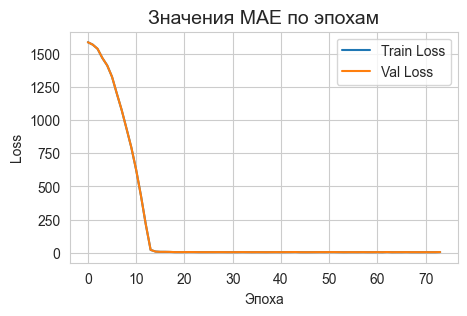


Лучшие результаты:
Train Loss: 5.4619
Val Loss: 5.5256
Время обучения: 6.82 сек


In [82]:
net = RegressionNet([12, 50, 100, 50, 1], drop_size=0)

trained_net = regression_net_trainer(
    net, X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor,
    loss_func=nn.L1Loss(),
    batch_size=44,
    learning_rate=0.006319178354742522,
    num_epochs=80,
    patience=10,
    printing=True,
    plot=True
)

### Анализ результатов

In [78]:
with torch.no_grad():
    pred_test = trained_net[0](X_test_tensor).flatten().numpy()
mae_test = mean_absolute_error(y_test, pred_test)
r2_test = r2_score(y_test, pred_test)
print("MAE для тестовой выборки:", mae_test)
print("R2 для тестовой выборки:", r2_test)

MAE для тестовой выборки: 5.599888332930627
R2 для тестовой выборки: 0.5052404224671003


Значение MAE на тестовых данных - 5.59, что полностью удовлетваряет требованиям заказчика. Модель достаточно устойчива, но её точность низка, она объясняет менее половины изменчивости данных (что можно увидель по низкому R2_score).

Оценка важности признаков для полносвязной нейронной сети требует особых подходов, поскольку нейросети — это "чёрные ящики", и их веса не всегда напрямую интерпретируемы.

Наилучший результат среди обычных моделей (и наиболее близкий к нашему) показала реализация линейной регрессии HuberRegressor (6,05 на кросс валидации). Это указывает на наличие линейных взаимосвязей. Основываясь на том, какие прихзнаки HuberRegressor посчитал наиболее важными, мы можем сделать косвенное предположение о наиболее важном признаке для итоговой нейронной сети.

In [79]:
X_train_transformed = pd.DataFrame(data_preprocessor.fit_transform(X_train), columns=X_train.columns)
X_test_transformed = pd.DataFrame(data_preprocessor.transform(X_test), columns=X_train.columns)

PermutationExplainer explainer: 583it [00:35, 16.51it/s]                                                               
C:\Users\HONOR\AppData\Local\Temp\ipykernel_10436\4012790843.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_transformed, plot_type="bar")


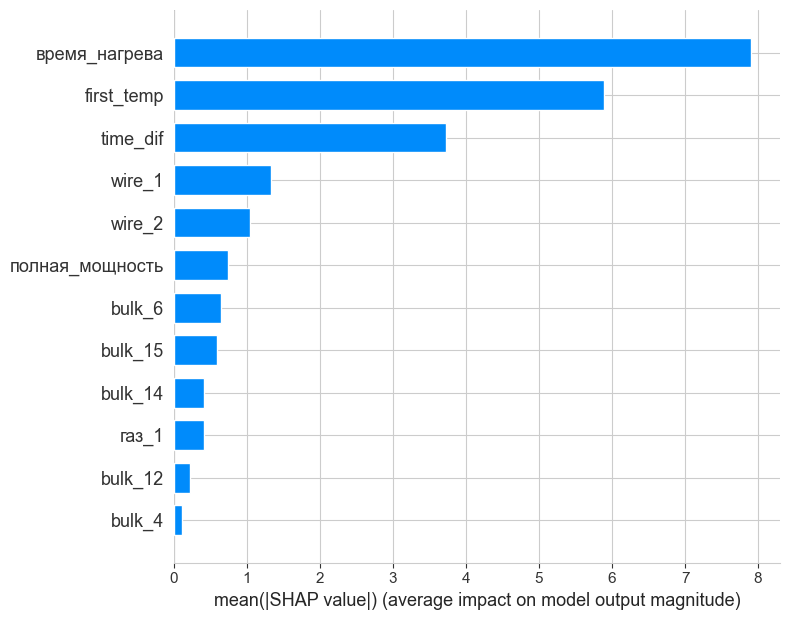

C:\Users\HONOR\AppData\Local\Temp\ipykernel_10436\4012790843.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_transformed)


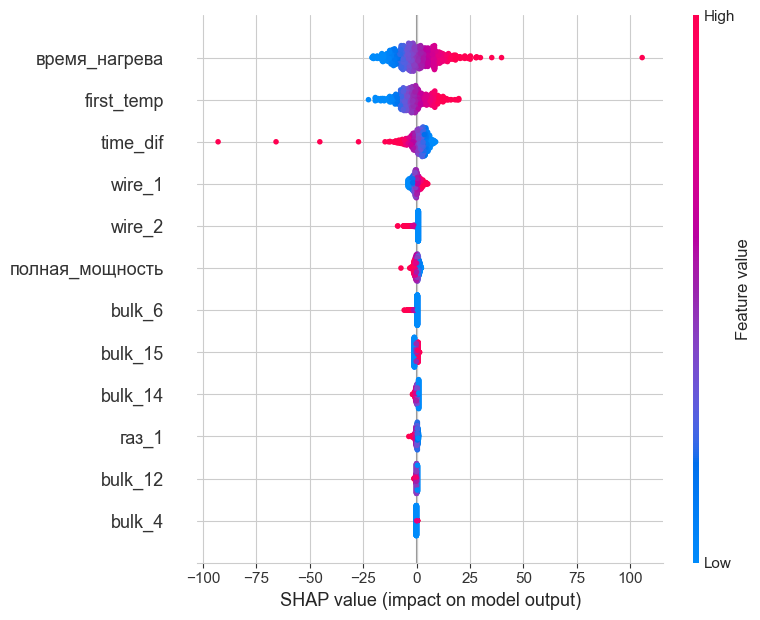

In [80]:
model = HuberRegressor()  
model.fit(X_train_transformed, y_train)

explainer = shap.Explainer(model.predict, X_train_transformed) 
shap_values = explainer(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, plot_type="bar")

shap.summary_plot(shap_values, X_test_transformed)

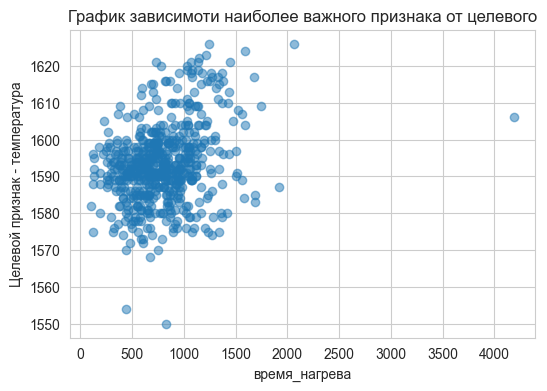

In [81]:
plt.figure(figsize=(6, 4))
plt.scatter(X_test['время_нагрева'], y_test, alpha=0.5)
plt.xlabel('время_нагрева')
plt.ylabel('Целевой признак - температура')
plt.title('График зависимоти наиболее важного признака от целевого')
plt.grid(True)
plt.show()

### Вывод
Наиболее важными признаками модель оценила:
1. время нагрева - чем боле этот признак, тем больше модель будет склоняться в сторону принятия более высокого значения
2. первоначальная температура - чем меньше боле этот признак, тем больше модель будет склоняться в сторону принятия более низкого значения
3. time_dif (разница между временем замера температур) - чем больше разница, тем дольше производилась обработка металла.

Хорошо что логика работы модели не противоречит естественной логике и физике материалов.

## Вывод

Задача данной работы состоит построении модели для предсказания температуры для металлургического комбината "Стальня птица". Для этого загружена база данных, из которой импортированы такие датасеты как data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time. На их основе создан итоговый датафрейм, в который вошли такие прихнаки как 'first_temp', 'time_dif', 'газ_1', 'bulk_4', 'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'время_нагрева', 'полная_мощность'. 

На полученных данных были опробованы 6 моделей регрессии, из которых наилучшие результаты оказались у HuberRegressor и нейронная сеть с наилучшем значением на тесте в 5.59 градусов. Наиболее важными признаками были оценены время нагрева и начальная температура сплава.